In [1]:
import pandas as pd
import numpy as np
import sys, zipfile, os, time
import matplotlib.pyplot as plt
import glob
import datetime
import urllib3
import cdsapi
import xarray
import shutil
import warnings
import pickle
import h5py
import netCDF4
warnings.filterwarnings('ignore')

sys.path.append(os.getcwd()+'/../cds-backend/code/')
import cds_eua3 as eua

In [2]:
def get_adj(station, var):
    import datetime
    """Compare created adjustment to downloaded adjustment
    """
    date0 = datetime.datetime.strptime('1900-01-01', "%Y-%m-%d")

    if var == 'RAOBCORE_bias_estimate':
        file = ('./Temperature_adjustment/0'+station+'/feedbackglobbincorrsave0'+station+'.nc')
    elif var == 'RISE_bias_estimate':
        file = glob.glob('./Temperature_adjustment/0'+station+'/*corrsave*rio24*'+station+'.nc')[0]
    data = eua.CDMDataset(file)
    
    breakdates = []
    for i in data.datum[:][0]:
        breakdates.append(date0 + datetime.timedelta(days=int(i)))

    press = data.press[:]
    nightadj = data.rasocorr[0,:]
    dayadj = data.rasocorr[1,:]

    c = cdsapi.Client()
    r = c.retrieve('insitu-comprehensive-upper-air-observation-network',
                   {'variable': 'temperature',
                    'optional':['obs_minus_bg','bias_estimate','RISE_bias_estimate', 'RICH_bias_estimate', 'RASE_bias_estimate', 'RAOBCORE_bias_estimate'],
                    'statid': station,
                    'pressure_level':[10,20,30,50,70,100,150,200,250,300,400,500,700,850,925,1000]
                   }
                  )
    r.download(target='download.zip')
    assert os.stat('download.zip').st_size == r.content_length, "Downloaded file is incomplete"
    z = zipfile.ZipFile('download.zip')
    z.extractall(path='./tocompare/cds_'+station)
    z.close()
    cdsfile = glob.glob('./tocompare/cds_'+ station +'/*.nc')
    cdsdata=eua.CDMDataset(cdsfile[0]).to_dataframe()
    daydata = cdsdata[cdsdata.time.dt.hour > 6][cdsdata.time.dt.hour <= 18]
    nightdata = cdsdata[cdsdata.time.dt.hour <= 6].append(cdsdata[cdsdata.time.dt.hour > 18])
    print(str(cdsdata.time.iloc[0]))#.year)+str(cdsdata.time.iloc[0].month)+str(cdsdata.time.iloc[0].day))
    
#     breakdates.append(str(cdsdata.time.iloc[0]))#.year)+str(cdsdata.time.iloc[0].month)+str(cdsdata.time.iloc[0].day))
    dates = breakdates
#     dates.reverse()
    print(dates)
    
    calc_day_out = {}
    calc_night_out = {}
    cds_day_out = {}
    cds_night_out = {}
    for i in [10,20,30,50,70,100,150,200,250,300,400,500,700,850,925,1000]:
        calc_day_out[str(i)]=[]
        calc_night_out[str(i)]=[]
        cds_day_out[str(i)]=[]
        cds_night_out[str(i)]=[]
    for i in range(len(dates)-1):
        for j in range(len(press)):
            try:
                d_adjd = dayadj[j][i]
                calc_day_out[str(int(press[j]))].append(d_adjd)
            except:
                calc_day_out[str(int(press[j]))].append(np.nan) 
            try:
                d_cdsd = daydata[daydata.plev == press[j]*100][daydata.time >= dates[i]][daydata.time < dates[i+1]]
                cds_day_out[str(int(press[j]))].append(d_cdsd[var].iloc[0])
            except:
                cds_day_out[str(int(press[j]))].append(np.nan)
            try:
                n_cdsd = nightdata[nightdata.plev == press[j]*100][nightdata.time >= dates[i]][nightdata.time < dates[i+1]]
                cds_night_out[str(int(press[j]))].append(n_cdsd[var].iloc[0])
            except:
                cds_night_out[str(int(press[j]))].append(np.nan)
            try:
                n_adjd = nightadj[j][i]
                calc_night_out[str(int(press[j]))].append(n_adjd)
            except:
                calc_night_out[str(int(press[j]))].append(np.nan)
                
    return dates, cds_day_out, cds_night_out, calc_day_out, calc_night_out

In [3]:
def plt_adj(dates, cdata, adata, plev, station, time, adj, save):
#     dates_list = [datetime.datetime.strptime(date, '%Y%m%d').date() for date in dates[1:]]
    fig, ax = plt.subplots()
    ax.scatter(dates[1:], cdata[str(plev)], label='CDS')
    ax.scatter(dates[1:], adata[str(plev)], label='Calc')

    ax.set(xlabel='breaks', ylabel='Adjustment: '+adj,
           title= str(station)+' Temperature '+str(plev)+' hPa '+time)
    ax.legend()
    ax.grid()
    
    if save:
        fig.savefig(str(station)+'_Temperature_'+str(plev)+'_hPa_'+time+'.png')
    plt.show()
    return

In [4]:
def get_sacadj(station, var):
    import datetime
    """Compare created solarangle corrected adjustment to downloaded adjustment
    """
    if var == 'RASE_bias_estimate':
        tarvar = 'bias'
    elif var == 'RICH_bias_estimate':
        tarvar = 'richbias'
    file = glob.glob('./Temperature_adjustment/0'+station+'/*ERA5bc*'+station+'.nc')[0]
    data = eua.CDMDataset(file)
    
    date0 = datetime.datetime.strptime('1900-01-01', "%Y-%m-%d")
#     dates = []
#     for i in data.datum[:]:
#         dates.append(date0 + datetime.timedelta(days=int(i)))
    
    lessdates = []
    basedatum = data.datum[:]
    for i in range(basedatum[0], basedatum[-1], 1000):
        lessdates.append(date0 + datetime.timedelta(days=int(i)))
    dates = lessdates
    
    press = data.press[:]
    print(press)
    nightadj = data[tarvar][0,:]
    dayadj = data[tarvar][1,:]

    c = cdsapi.Client()
    r = c.retrieve('insitu-comprehensive-upper-air-observation-network',
                   {'variable': 'temperature',
                    'optional':['obs_minus_bg','bias_estimate','RISE_bias_estimate', 'RICH_bias_estimate', 'RASE_bias_estimate', 'RAOBCORE_bias_estimate'],
                    'statid': station,
                    'pressure_level':[10,20,30,50,70,100,150,200,250,300,400,500,700,850,925,1000]
                   }
                  )
    r.download(target='download.zip')
    assert os.stat('download.zip').st_size == r.content_length, "Downloaded file is incomplete"
    z = zipfile.ZipFile('download.zip')
    z.extractall(path='./tocompare/cds_'+station)
    z.close()
    cdsfile = glob.glob('./tocompare/cds_'+ station +'/*.nc')
    cdsdata=eua.CDMDataset(cdsfile[0]).to_dataframe()
    daydata = cdsdata[cdsdata.time.dt.hour > 6][cdsdata.time.dt.hour <= 18]
    nightdata = cdsdata[cdsdata.time.dt.hour <= 6].append(cdsdata[cdsdata.time.dt.hour > 18])
    print(str(cdsdata.time.iloc[0]))#.year)+str(cdsdata.time.iloc[0].month)+str(cdsdata.time.iloc[0].day))
    
    calc_day_out = {}
    calc_night_out = {}
    cds_day_out = {}
    cds_night_out = {}
    for i in [10,20,30,50,70,100,150,200,250,300,400,500,700,850,925,1000]:
        calc_day_out[str(i)]=[]
        calc_night_out[str(i)]=[]
        cds_day_out[str(i)]=[]
        cds_night_out[str(i)]=[]
        
    for i in range(len(dates)-1):
        for j in range(len(press)):
            try:
                d_adjd = dayadj[j][i*300]
                calc_day_out[str(int(press[j]))].append(d_adjd)
            except:
                calc_day_out[str(int(press[j]))].append(np.nan) 
            try:
                d_cdsd = daydata[daydata.plev == press[j]*100][daydata.time >= dates[i]][daydata.time < dates[i+1]]
                cds_day_out[str(int(press[j]))].append(d_cdsd[var].iloc[0])
            except:
                cds_day_out[str(int(press[j]))].append(np.nan)
            try:
                n_cdsd = nightdata[nightdata.plev == press[j]*100][nightdata.time >= dates[i]][nightdata.time < dates[i+1]]
                cds_night_out[str(int(press[j]))].append(n_cdsd[var].iloc[0])
            except:
                cds_night_out[str(int(press[j]))].append(np.nan)
            try:
                n_adjd = nightadj[j][i*300]
                calc_night_out[str(int(press[j]))].append(n_adjd)
            except:
                calc_night_out[str(int(press[j]))].append(np.nan)
                
    return dates, cds_day_out, cds_night_out, calc_day_out, calc_night_out

In [5]:
# def get_sacadj(station, var):
#     import datetime
#     """Compare created solarangle corrected adjustment to downloaded adjustment
#     """
#     if var == 'RASE_bias_estimate':
#         tarvar = 'bias'
#     elif var == 'RICH_bias_estimate':
#         tarvar = 'richbias'
#     file = glob.glob('./Temperature_adjustment/0'+station+'/*ERA5bc*'+station+'.nc')[0]
#     data = eua.CDMDataset(file)
    
#     date0 = datetime.datetime.strptime('1900-01-01', "%Y-%m-%d")
#     dates = []
#     for i in data.datum[:]:
#         dates.append(date0 + datetime.timedelta(days=int(i)))
    
#     press = data.press[:]
#     nightadj = data[tarvar][0,:]
#     dayadj = data[tarvar][1,:]

#     c = cdsapi.Client()
#     r = c.retrieve('insitu-comprehensive-upper-air-observation-network',
#                    {'variable': 'temperature',
#                     'optional':['obs_minus_bg','bias_estimate','RISE_bias_estimate', 'RICH_bias_estimate', 'RASE_bias_estimate', 'RAOBCORE_bias_estimate'],
#                     'statid': station,
#                     'pressure_level':[10,20,30,50,70,100,150,200,250,300,400,500,700,850,925,1000]
#                    }
#                   )
#     r.download(target='download.zip')
#     assert os.stat('download.zip').st_size == r.content_length, "Downloaded file is incomplete"
#     z = zipfile.ZipFile('download.zip')
#     z.extractall(path='./tocompare/cds_'+station)
#     z.close()
#     cdsfile = glob.glob('./tocompare/cds_'+ station +'/*.nc')
#     cdsdata=eua.CDMDataset(cdsfile[0]).to_dataframe()
#     daydata = cdsdata[cdsdata.time.dt.hour > 6][cdsdata.time.dt.hour <= 18]
#     day_cdsdates = daydata.time
#     nightdata = cdsdata[cdsdata.time.dt.hour <= 6].append(cdsdata[cdsdata.time.dt.hour > 18])
#     night_cdsdates = nightdata.time
    
#     calc_day_out = {}
#     calc_night_out = {}
#     cds_day_out = {}
#     cds_night_out = {}
#     print('dates', len(dates))
#     for j in range(len(press)):
#         calc_day_out[str(int(press[j]))] = dayadj[j][:]
#         cds_day_out[str(int(press[j]))] = daydata[daydata.plev == press[j]*100]
#         cds_night_out[str(int(press[j]))] = nightdata[nightdata.plev == press[j]*100]
#         calc_night_out[str(int(press[j]))] = nightadj[j][:]
#         if press[j] in [100, 500, 850]:
#             plt_sacadj(dates, nightdata[nightdata.plev == press[j]*100].time, nightdata[nightdata.plev == press[j]*100][var], nightadj[j][:], press[j], station, 'night', var, save=False)
#             plt_sacadj(dates, daydata[daydata.plev == press[j]*100].time, daydata[daydata.plev == press[j]*100][var], dayadj[j][:], press[j], station, 'day', var, save=False)

#     return dates, day_cdsdates, night_cdsdates, calc_day_out, calc_night_out, cds_day_out, cds_night_out

In [6]:
# def plt_sacadj(dates, cdsdates, cdata, adata, plev, station, time, adj, save):
# #     dates_list = [datetime.datetime.strptime(date, '%Y%m%d').date() for date in dates[1:]]
#     fig, ax = plt.subplots()
#     ax.scatter(cdsdates, cdata, label='CDS')
#     ax.scatter(dates, adata, label='Calc')

#     ax.set(xlabel='breaks', ylabel='Adjustment: '+adj,
#            title= str(station)+' Temperature '+str(plev)+' hPa '+time)
#     ax.legend()
#     ax.grid()
    
#     if save:
#         fig.savefig(str(station)+'_Temperature_'+str(plev)+'_hPa_'+time+'.png')
#     plt.show()
#     return

In [7]:
# station = '70219'
# adj = 'RICH_bias_estimate'
# dates,cdsdd, cdsnd, cd, cn, ad, an = get_sacadj(station, adj)

2021-04-29 11:34:58,693 INFO Welcome to the CDS
2021-04-29 11:34:58,695 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-04-29 11:34:58,921 INFO Request is completed
2021-04-29 11:34:58,922 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1619430583.4392266-16861-7-46ce0851-f55c-451f-a96d-294334bd80dd.zip to download.zip (28.1M)
2021-04-29 11:35:00,063 INFO Download rate 24.7M/s  
2021-04-29 11:35:00,164 INFO Reading Profile on slice(None, None, None)
2021-04-29 11:35:04,574 INFO Note: NumExpr detected 56 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2021-04-29 11:35:04,575 INFO NumExpr defaulting to 8 threads.


1948-01-01 03:00:00
[datetime.datetime(1900, 1, 2, 0, 0), datetime.datetime(1950, 4, 13, 0, 0), datetime.datetime(1952, 6, 18, 0, 0), datetime.datetime(1955, 7, 21, 0, 0), datetime.datetime(1956, 8, 5, 0, 0), datetime.datetime(1958, 8, 13, 0, 0), datetime.datetime(1960, 11, 12, 0, 0), datetime.datetime(1963, 9, 7, 0, 0), datetime.datetime(1964, 12, 21, 0, 0), datetime.datetime(1970, 9, 7, 0, 0), datetime.datetime(1975, 8, 7, 0, 0), datetime.datetime(1977, 12, 4, 0, 0), datetime.datetime(1980, 9, 14, 0, 0), datetime.datetime(1982, 11, 21, 0, 0), datetime.datetime(1984, 1, 27, 0, 0), datetime.datetime(1989, 7, 1, 0, 0), datetime.datetime(1992, 2, 28, 0, 0), datetime.datetime(1995, 6, 12, 0, 0), datetime.datetime(1997, 7, 12, 0, 0), datetime.datetime(1999, 9, 5, 0, 0), datetime.datetime(2009, 3, 21, 0, 0), datetime.datetime(2023, 3, 15, 0, 0)]


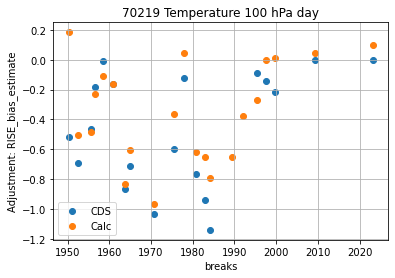

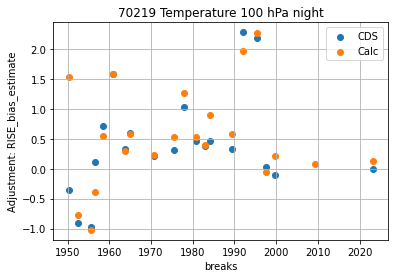

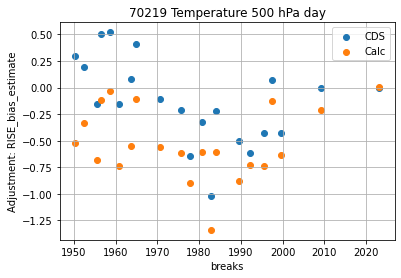

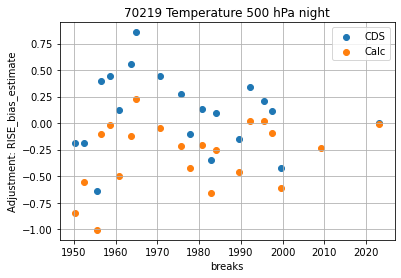

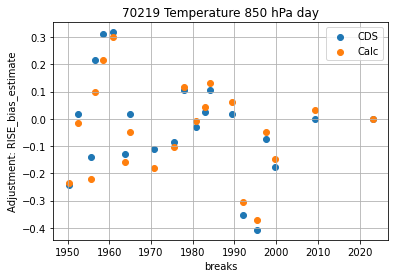

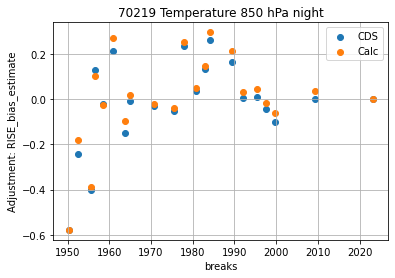

In [8]:
station = '70219'
adj = 'RISE_bias_estimate'
dates, cd, cn, ad, an = get_adj(station, adj)

plt_adj(dates, cd, ad, 100, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 100, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 500, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 500, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 850, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 850, station, 'night', adj, save=False)

2021-04-29 11:35:19,215 INFO Welcome to the CDS
2021-04-29 11:35:19,216 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-04-29 11:35:19,335 INFO Request is completed
2021-04-29 11:35:19,336 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1619430583.4392266-16861-7-46ce0851-f55c-451f-a96d-294334bd80dd.zip to download.zip (28.1M)
  0%|          | 0.00/28.1M [00:00<?, ?B/s]

[  10.   20.   30.   50.   70.  100.  150.  200.  250.  300.  400.  500.
  700.  850.  925. 1000.]


2021-04-29 11:35:20,333 INFO Download rate 28.2M/s  
2021-04-29 11:35:20,431 INFO Reading Profile on slice(None, None, None)


1948-01-01 03:00:00


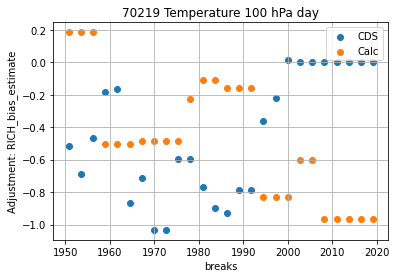

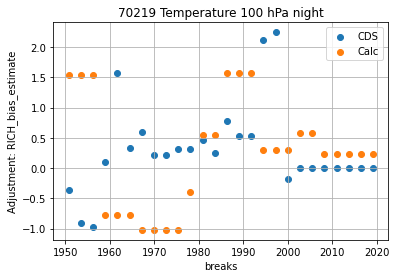

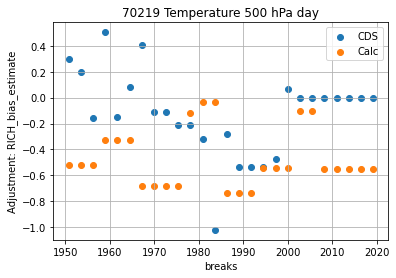

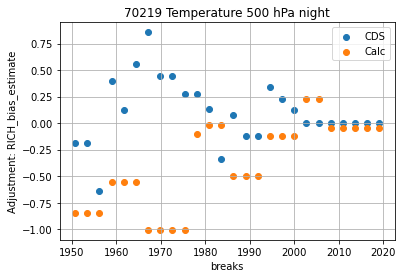

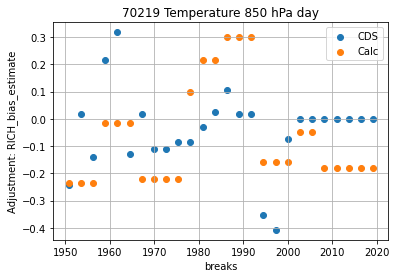

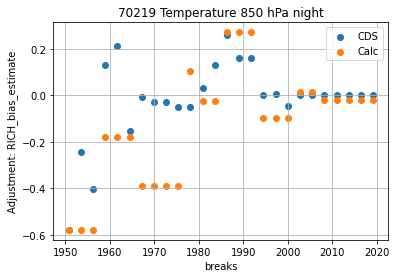

In [9]:
station = '70219'
adj = 'RICH_bias_estimate'
dates, cd, cn, ad, an = get_sacadj(station, adj)

plt_adj(dates, cd, ad, 100, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 100, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 500, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 500, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 850, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 850, station, 'night', adj, save=False)

2021-04-29 11:35:42,787 INFO Welcome to the CDS
2021-04-29 11:35:42,788 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-04-29 11:35:42,868 INFO Request is completed
2021-04-29 11:35:42,869 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1619430583.4392266-16861-7-46ce0851-f55c-451f-a96d-294334bd80dd.zip to download.zip (28.1M)
2021-04-29 11:35:44,184 INFO Download rate 21.4M/s  
2021-04-29 11:35:44,323 INFO Reading Profile on slice(None, None, None)


1948-01-01 03:00:00
[datetime.datetime(1900, 1, 2, 0, 0), datetime.datetime(1950, 4, 12, 0, 0), datetime.datetime(1952, 6, 17, 0, 0), datetime.datetime(1955, 7, 20, 0, 0), datetime.datetime(1956, 8, 4, 0, 0), datetime.datetime(1958, 8, 12, 0, 0), datetime.datetime(1960, 11, 11, 0, 0), datetime.datetime(1963, 9, 6, 0, 0), datetime.datetime(1964, 12, 20, 0, 0), datetime.datetime(1970, 9, 6, 0, 0), datetime.datetime(1975, 8, 6, 0, 0), datetime.datetime(1977, 12, 3, 0, 0), datetime.datetime(1980, 9, 13, 0, 0), datetime.datetime(1982, 11, 20, 0, 0), datetime.datetime(1984, 1, 26, 0, 0), datetime.datetime(1989, 6, 30, 0, 0), datetime.datetime(1992, 2, 27, 0, 0), datetime.datetime(1995, 6, 11, 0, 0), datetime.datetime(1997, 7, 11, 0, 0), datetime.datetime(1999, 9, 4, 0, 0), datetime.datetime(2009, 3, 20, 0, 0), datetime.datetime(2023, 3, 15, 0, 0)]


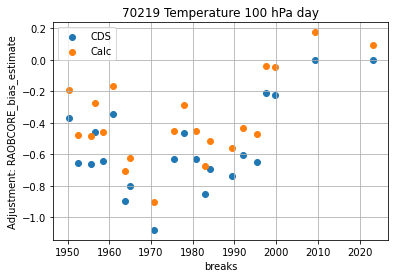

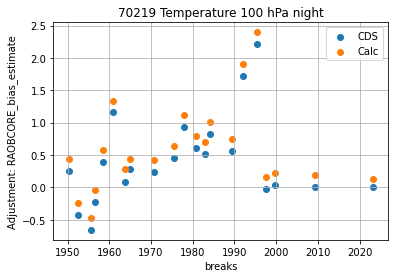

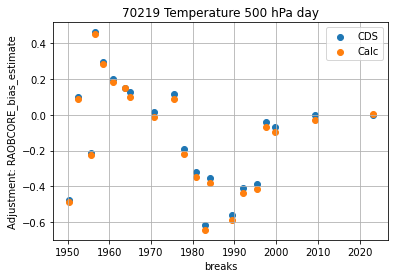

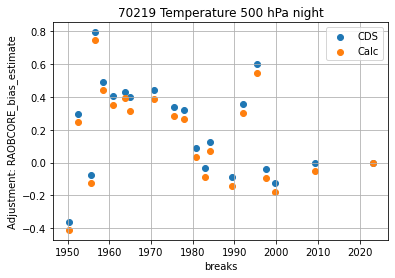

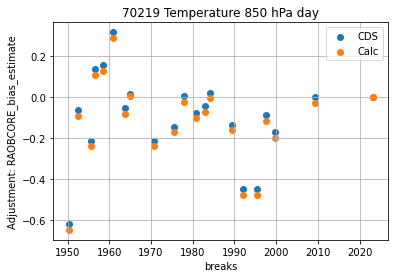

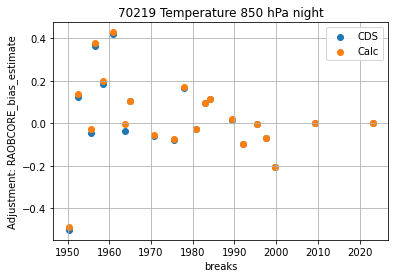

In [10]:
station = '70219'
adj = 'RAOBCORE_bias_estimate'
dates, cd, cn, ad, an = get_adj(station, adj)
plt_adj(dates, cd, ad, 100, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 100, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 500, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 500, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 850, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 850, station, 'night', adj, save=False)

2021-04-29 11:36:04,987 INFO Welcome to the CDS
2021-04-29 11:36:04,988 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-04-29 11:36:05,068 INFO Request is completed
2021-04-29 11:36:05,069 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1619430583.4392266-16861-7-46ce0851-f55c-451f-a96d-294334bd80dd.zip to download.zip (28.1M)
  0%|          | 0.00/28.1M [00:00<?, ?B/s]

[  10.   20.   30.   50.   70.  100.  150.  200.  250.  300.  400.  500.
  700.  850.  925. 1000.]


2021-04-29 11:36:06,318 INFO Download rate 22.5M/s  
2021-04-29 11:36:06,438 INFO Reading Profile on slice(None, None, None)


1948-01-01 03:00:00


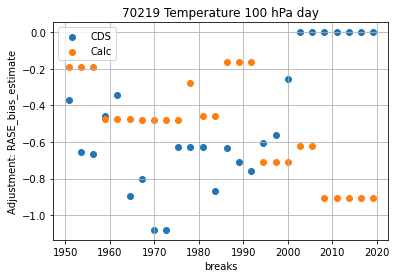

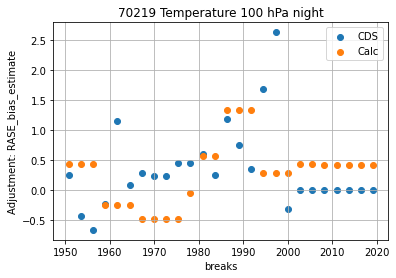

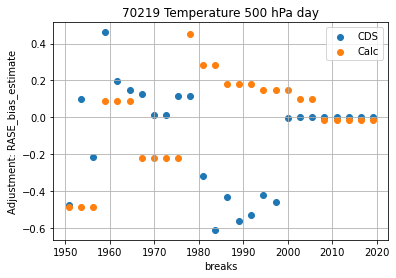

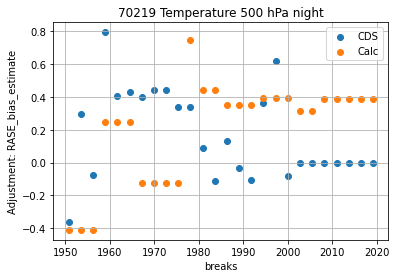

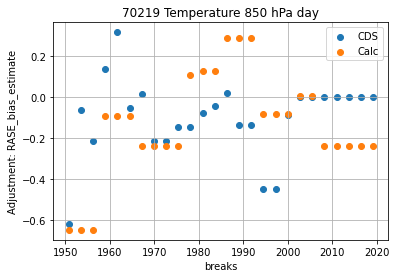

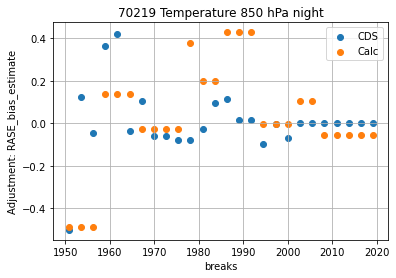

In [11]:
station = '70219'
adj = 'RASE_bias_estimate'
dates, cd, cn, ad, an = get_sacadj(station, adj)
plt_adj(dates, cd, ad, 100, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 100, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 500, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 500, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 850, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 850, station, 'night', adj, save=False)

2021-04-29 11:36:28,826 INFO Welcome to the CDS
2021-04-29 11:36:28,827 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-04-29 11:36:28,974 INFO Request is completed
2021-04-29 11:36:28,975 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1619442520.2651842-22152-13-aa2a8e19-41a7-483e-989b-4b5c889b4b2b.zip to download.zip (30.7M)
2021-04-29 11:36:30,279 INFO Download rate 23.6M/s  
2021-04-29 11:36:30,593 INFO Reading Profile on slice(None, None, None)


1948-12-11 03:00:00
[datetime.datetime(1900, 1, 2, 0, 0), datetime.datetime(1952, 6, 18, 0, 0), datetime.datetime(1956, 4, 28, 0, 0), datetime.datetime(1958, 5, 19, 0, 0), datetime.datetime(1959, 4, 1, 0, 0), datetime.datetime(1960, 5, 27, 0, 0), datetime.datetime(1965, 7, 12, 0, 0), datetime.datetime(1967, 11, 27, 0, 0), datetime.datetime(1972, 3, 13, 0, 0), datetime.datetime(1975, 1, 4, 0, 0), datetime.datetime(1978, 12, 31, 0, 0), datetime.datetime(1981, 1, 25, 0, 0), datetime.datetime(1981, 10, 14, 0, 0), datetime.datetime(1984, 5, 31, 0, 0), datetime.datetime(1988, 1, 26, 0, 0), datetime.datetime(1990, 6, 14, 0, 0), datetime.datetime(1995, 11, 22, 0, 0), datetime.datetime(2003, 4, 26, 0, 0), datetime.datetime(2011, 6, 1, 0, 0), datetime.datetime(2014, 11, 12, 0, 0), datetime.datetime(2023, 3, 15, 0, 0)]


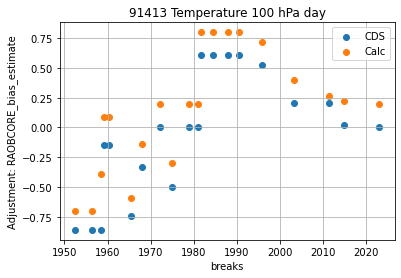

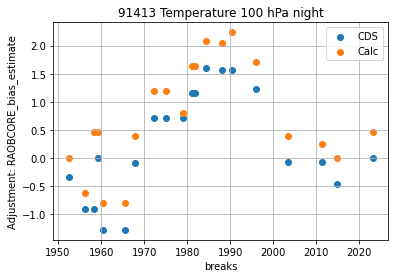

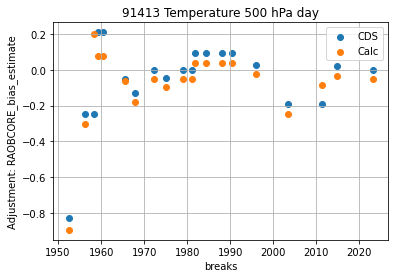

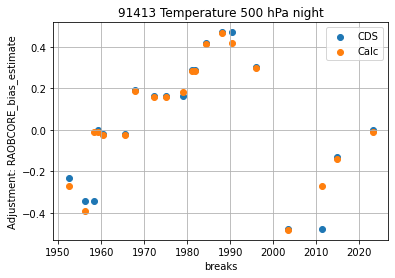

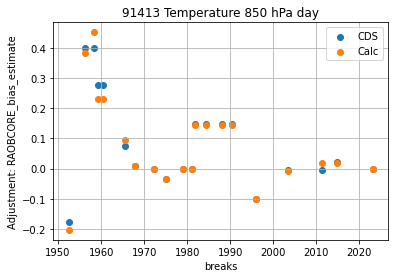

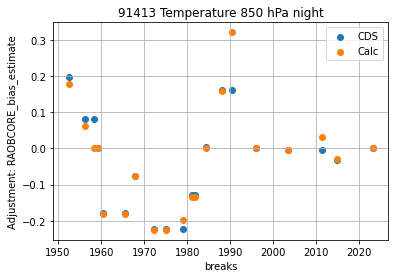

In [12]:
station = '91413'
adj = 'RAOBCORE_bias_estimate'
dates, cd, cn, ad, an = get_adj(station, adj)
plt_adj(dates, cd, ad, 100, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 100, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 500, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 500, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 850, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 850, station, 'night', adj, save=False)

2021-04-29 11:36:47,883 INFO Welcome to the CDS
2021-04-29 11:36:47,884 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-04-29 11:36:47,954 INFO Request is completed
2021-04-29 11:36:47,955 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1619442520.2651842-22152-13-aa2a8e19-41a7-483e-989b-4b5c889b4b2b.zip to download.zip (30.7M)
  0%|          | 0.00/30.7M [00:00<?, ?B/s]

[  10.   20.   30.   50.   70.  100.  150.  200.  250.  300.  400.  500.
  700.  850.  925. 1000.]


2021-04-29 11:36:49,686 INFO Download rate 17.7M/s  
2021-04-29 11:36:49,855 INFO Reading Profile on slice(None, None, None)


1948-12-11 03:00:00


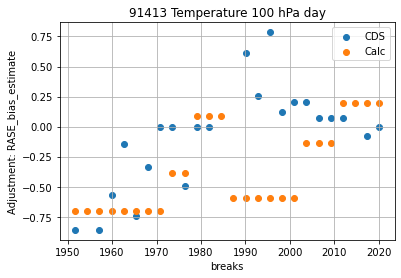

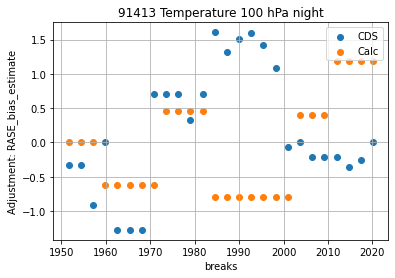

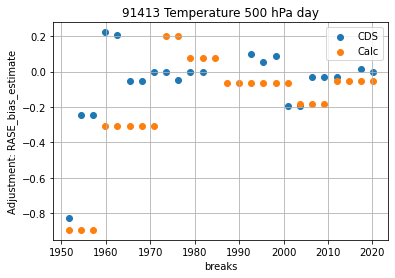

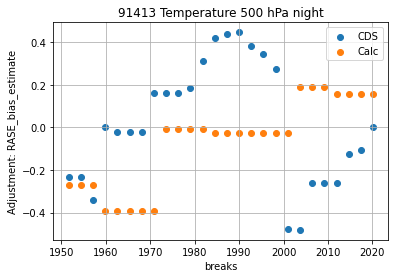

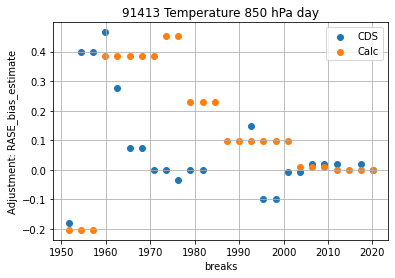

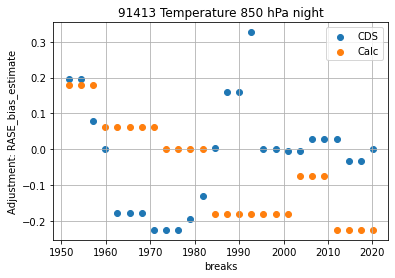

In [13]:
station = '91413'
adj = 'RASE_bias_estimate'
dates, cd, cn, ad, an = get_sacadj(station, adj)
plt_adj(dates, cd, ad, 100, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 100, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 500, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 500, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 850, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 850, station, 'night', adj, save=False)

2021-04-29 11:37:10,575 INFO Welcome to the CDS
2021-04-29 11:37:10,576 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-04-29 11:37:10,646 INFO Request is completed
2021-04-29 11:37:10,647 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1619442520.2651842-22152-13-aa2a8e19-41a7-483e-989b-4b5c889b4b2b.zip to download.zip (30.7M)
2021-04-29 11:37:12,290 INFO Download rate 18.7M/s  
2021-04-29 11:37:12,410 INFO Reading Profile on slice(None, None, None)


1948-12-11 03:00:00
[datetime.datetime(1900, 1, 2, 0, 0), datetime.datetime(1952, 6, 19, 0, 0), datetime.datetime(1956, 4, 29, 0, 0), datetime.datetime(1958, 5, 20, 0, 0), datetime.datetime(1959, 4, 2, 0, 0), datetime.datetime(1960, 5, 28, 0, 0), datetime.datetime(1972, 3, 14, 0, 0), datetime.datetime(1975, 1, 5, 0, 0), datetime.datetime(1979, 1, 1, 0, 0), datetime.datetime(1981, 1, 26, 0, 0), datetime.datetime(1981, 10, 15, 0, 0), datetime.datetime(1984, 6, 1, 0, 0), datetime.datetime(1988, 1, 27, 0, 0), datetime.datetime(1990, 6, 15, 0, 0), datetime.datetime(1995, 11, 23, 0, 0), datetime.datetime(2003, 4, 27, 0, 0), datetime.datetime(2011, 6, 2, 0, 0), datetime.datetime(2014, 11, 13, 0, 0), datetime.datetime(2023, 3, 15, 0, 0)]


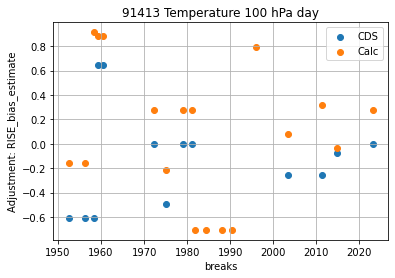

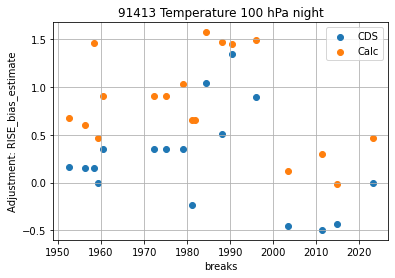

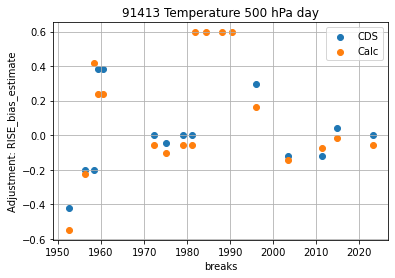

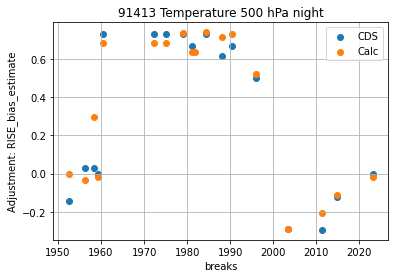

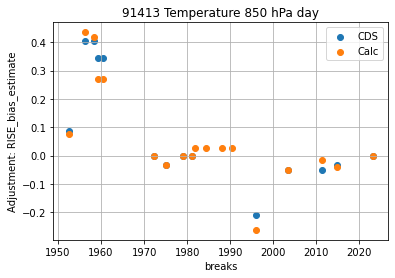

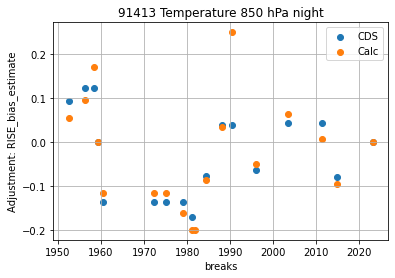

In [14]:
station = '91413'
adj = 'RISE_bias_estimate'
dates, cd, cn, ad, an = get_adj(station, adj)
plt_adj(dates, cd, ad, 100, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 100, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 500, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 500, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 850, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 850, station, 'night', adj, save=False)

2021-04-29 11:37:28,842 INFO Welcome to the CDS
2021-04-29 11:37:28,843 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-04-29 11:37:28,913 INFO Request is completed
2021-04-29 11:37:28,914 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1619442520.2651842-22152-13-aa2a8e19-41a7-483e-989b-4b5c889b4b2b.zip to download.zip (30.7M)
  0%|          | 0.00/30.7M [00:00<?, ?B/s]

[  10.   20.   30.   50.   70.  100.  150.  200.  250.  300.  400.  500.
  700.  850.  925. 1000.]


2021-04-29 11:37:30,877 INFO Download rate 15.7M/s  
2021-04-29 11:37:31,005 INFO Reading Profile on slice(None, None, None)


1948-12-11 03:00:00


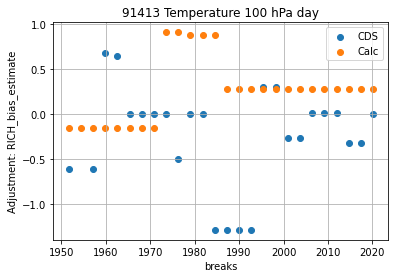

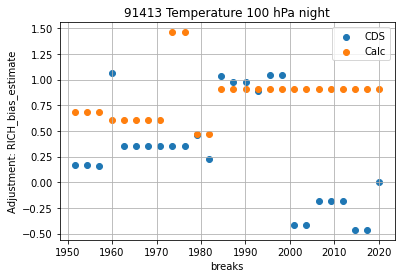

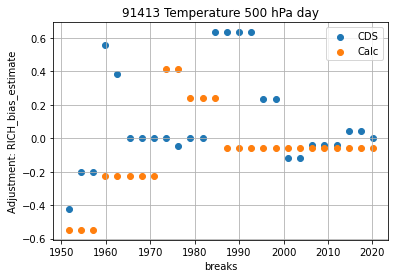

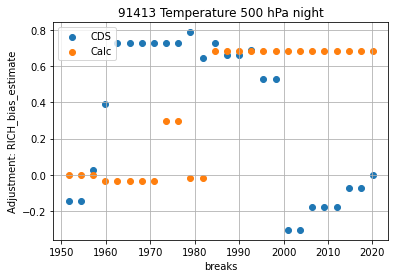

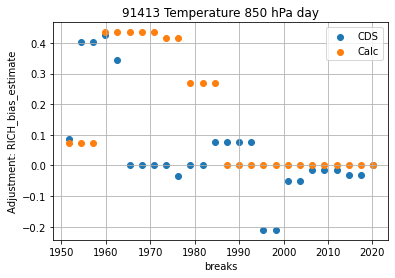

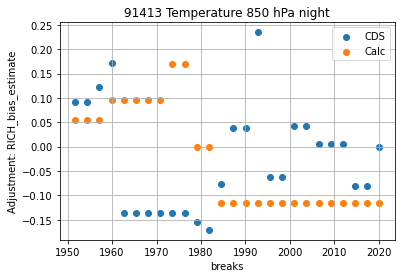

In [15]:
station = '91413'
adj = 'RICH_bias_estimate'
dates, cd, cn, ad, an = get_sacadj(station, adj)
plt_adj(dates, cd, ad, 100, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 100, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 500, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 500, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 850, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 850, station, 'night', adj, save=False)

2021-04-29 11:37:51,186 INFO Welcome to the CDS
2021-04-29 11:37:51,187 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-04-29 11:37:51,261 INFO Request is completed
2021-04-29 11:37:51,262 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data1/adaptor.comprehensive_upper_air.retrieve-1619430493.9770315-17332-9-5b04736a-b6fb-42b3-9245-1237f01efa80.zip to download.zip (43.3M)
2021-04-29 11:37:57,119 INFO Download rate 7.4M/s   
2021-04-29 11:37:57,340 INFO Reading Profile on slice(None, None, None)


1905-04-04 06:00:00
[datetime.datetime(1900, 1, 2, 0, 0), datetime.datetime(1952, 7, 2, 0, 0), datetime.datetime(1957, 1, 21, 0, 0), datetime.datetime(1960, 1, 16, 0, 0), datetime.datetime(1962, 2, 8, 0, 0), datetime.datetime(1963, 2, 11, 0, 0), datetime.datetime(1968, 1, 3, 0, 0), datetime.datetime(1970, 3, 3, 0, 0), datetime.datetime(1973, 4, 30, 0, 0), datetime.datetime(1979, 11, 2, 0, 0), datetime.datetime(1984, 8, 6, 0, 0), datetime.datetime(1987, 1, 17, 0, 0), datetime.datetime(1989, 4, 2, 0, 0), datetime.datetime(1991, 2, 16, 0, 0), datetime.datetime(1992, 3, 24, 0, 0), datetime.datetime(1994, 10, 12, 0, 0), datetime.datetime(2004, 5, 12, 0, 0), datetime.datetime(2006, 7, 1, 0, 0), datetime.datetime(2010, 7, 10, 0, 0), datetime.datetime(2017, 2, 3, 0, 0), datetime.datetime(2023, 3, 15, 0, 0)]


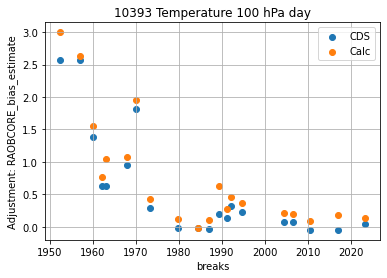

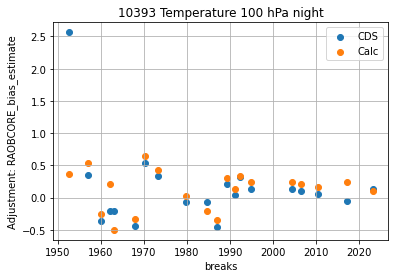

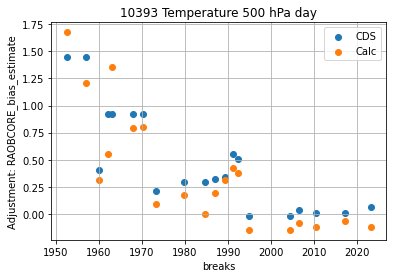

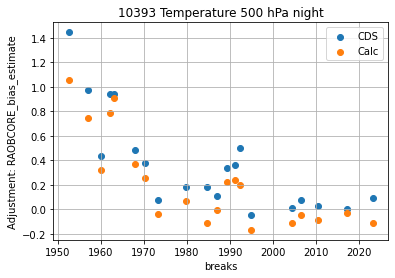

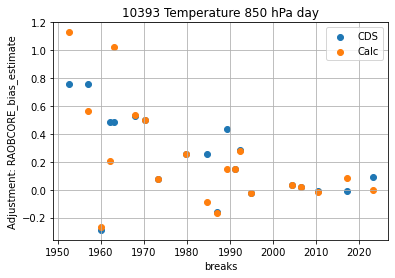

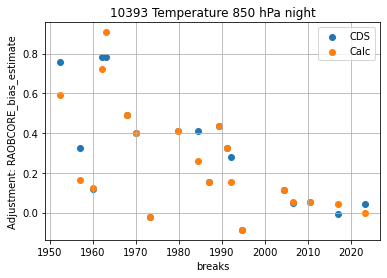

In [16]:
station = '10393'
adj = 'RAOBCORE_bias_estimate'
dates, cd, cn, ad, an = get_adj(station, adj)
plt_adj(dates, cd, ad, 100, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 100, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 500, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 500, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 850, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 850, station, 'night', adj, save=False)

2021-04-29 11:38:33,085 INFO Welcome to the CDS
2021-04-29 11:38:33,086 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


[  10.   20.   30.   50.   70.  100.  150.  200.  250.  300.  400.  500.
  700.  850.  925. 1000.]


2021-04-29 11:38:33,306 INFO Request is completed
2021-04-29 11:38:33,307 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data1/adaptor.comprehensive_upper_air.retrieve-1619430493.9770315-17332-9-5b04736a-b6fb-42b3-9245-1237f01efa80.zip to download.zip (43.3M)
2021-04-29 11:38:44,882 INFO Download rate 3.7M/s   
2021-04-29 11:38:45,055 INFO Reading Profile on slice(None, None, None)


1905-04-04 06:00:00


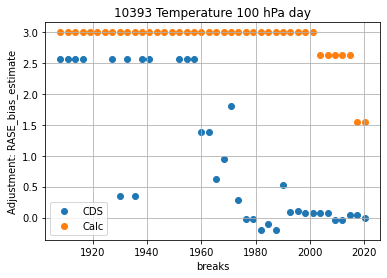

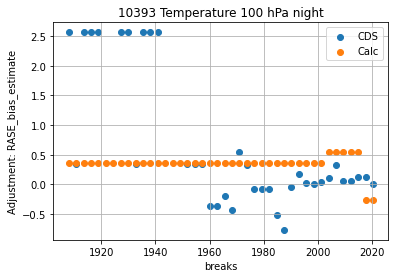

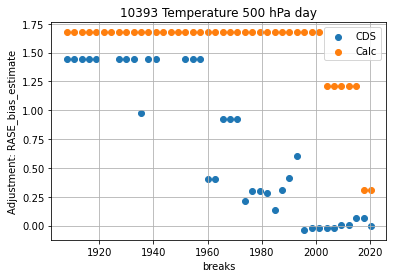

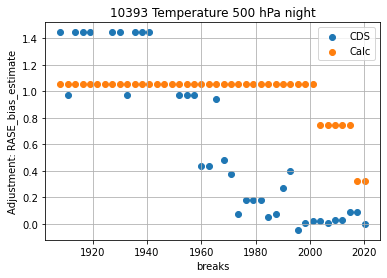

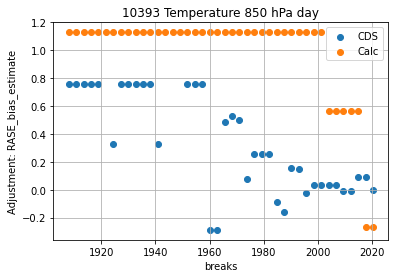

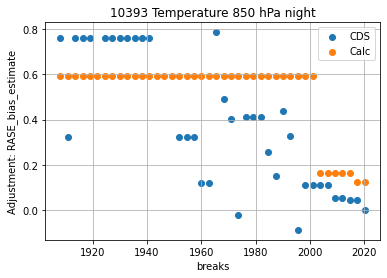

In [17]:
station = '10393'
adj = 'RASE_bias_estimate'
dates, cd, cn, ad, an = get_sacadj(station, adj)
plt_adj(dates, cd, ad, 100, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 100, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 500, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 500, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 850, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 850, station, 'night', adj, save=False)

2021-04-29 11:39:46,118 INFO Welcome to the CDS
2021-04-29 11:39:46,119 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-04-29 11:39:46,294 INFO Request is completed
2021-04-29 11:39:46,294 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data1/adaptor.comprehensive_upper_air.retrieve-1619430493.9770315-17332-9-5b04736a-b6fb-42b3-9245-1237f01efa80.zip to download.zip (43.3M)
2021-04-29 11:39:53,652 INFO Download rate 5.9M/s   
2021-04-29 11:39:53,817 INFO Reading Profile on slice(None, None, None)


1905-04-04 06:00:00
[datetime.datetime(1900, 1, 2, 0, 0), datetime.datetime(1952, 7, 3, 0, 0), datetime.datetime(1957, 1, 22, 0, 0), datetime.datetime(1960, 1, 17, 0, 0), datetime.datetime(1962, 2, 9, 0, 0), datetime.datetime(1963, 2, 12, 0, 0), datetime.datetime(1968, 1, 4, 0, 0), datetime.datetime(1970, 3, 4, 0, 0), datetime.datetime(1973, 5, 1, 0, 0), datetime.datetime(1979, 11, 3, 0, 0), datetime.datetime(1984, 8, 7, 0, 0), datetime.datetime(1987, 1, 18, 0, 0), datetime.datetime(1989, 4, 3, 0, 0), datetime.datetime(1991, 2, 17, 0, 0), datetime.datetime(1992, 3, 25, 0, 0), datetime.datetime(1994, 10, 13, 0, 0), datetime.datetime(2004, 5, 13, 0, 0), datetime.datetime(2006, 7, 2, 0, 0), datetime.datetime(2010, 7, 11, 0, 0), datetime.datetime(2017, 2, 4, 0, 0), datetime.datetime(2023, 3, 15, 0, 0)]


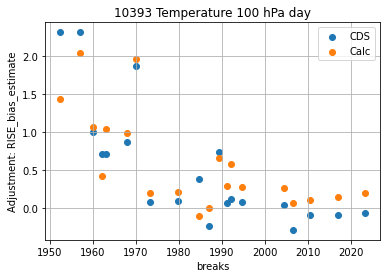

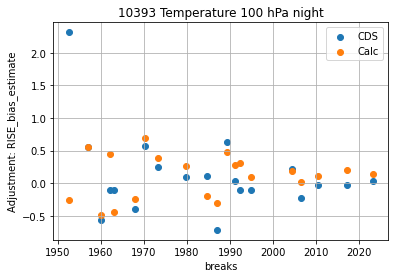

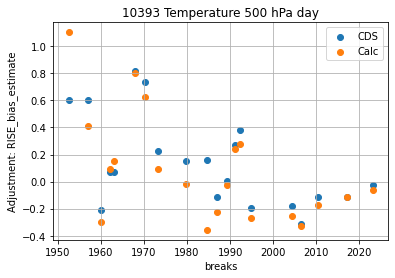

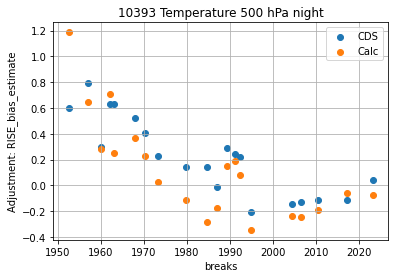

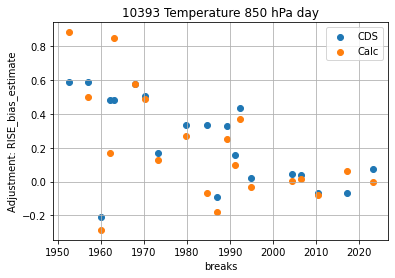

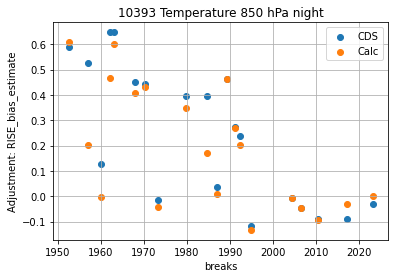

In [18]:
station = '10393'
adj = 'RISE_bias_estimate'
dates, cd, cn, ad, an = get_adj(station, adj)
plt_adj(dates, cd, ad, 100, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 100, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 500, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 500, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 850, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 850, station, 'night', adj, save=False)

2021-04-29 11:40:28,532 INFO Welcome to the CDS
2021-04-29 11:40:28,533 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


[  10.   20.   30.   50.   70.  100.  150.  200.  250.  300.  400.  500.
  700.  850.  925. 1000.]


2021-04-29 11:40:28,849 INFO Request is completed
2021-04-29 11:40:28,850 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data1/adaptor.comprehensive_upper_air.retrieve-1619430493.9770315-17332-9-5b04736a-b6fb-42b3-9245-1237f01efa80.zip to download.zip (43.3M)
2021-04-29 11:40:36,072 INFO Download rate 6M/s     
2021-04-29 11:40:36,245 INFO Reading Profile on slice(None, None, None)


1905-04-04 06:00:00


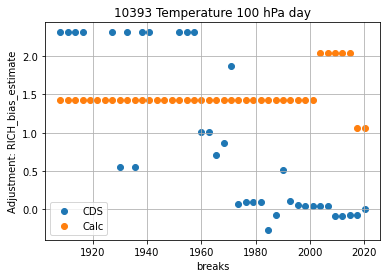

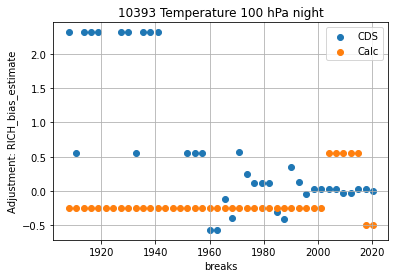

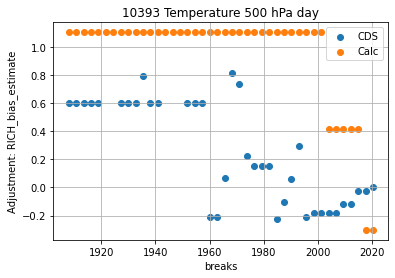

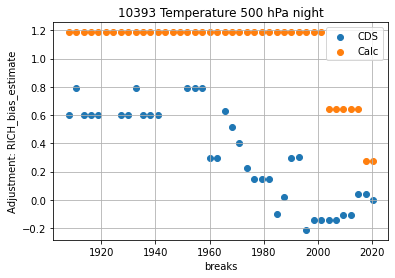

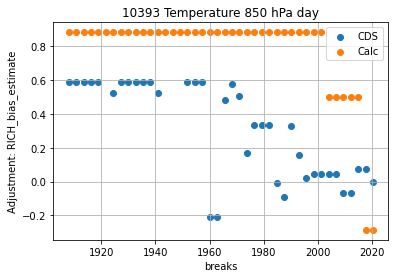

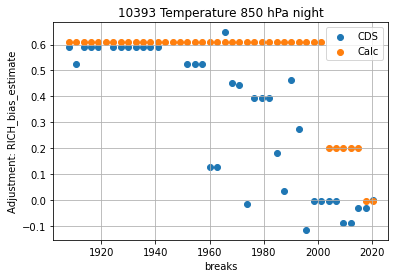

In [19]:
station = '10393'
adj = 'RICH_bias_estimate'
dates, cd, cn, ad, an = get_sacadj(station, adj)
plt_adj(dates, cd, ad, 100, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 100, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 500, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 500, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 850, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 850, station, 'night', adj, save=False)

2021-04-29 11:41:38,855 INFO Welcome to the CDS
2021-04-29 11:41:38,856 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-04-29 11:41:39,029 INFO Request is completed
2021-04-29 11:41:39,030 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data2/adaptor.comprehensive_upper_air.retrieve-1619418957.6919405-22674-5-9bd54766-c124-49e5-9fde-f2fdec5cb266.zip to download.zip (29M)
2021-04-29 11:41:42,751 INFO Download rate 7.8M/s   
2021-04-29 11:41:42,853 INFO Reading Profile on slice(None, None, None)


1925-01-24 09:22:00
[datetime.datetime(1900, 1, 2, 0, 0), datetime.datetime(1950, 2, 25, 0, 0), datetime.datetime(1951, 9, 12, 0, 0), datetime.datetime(1954, 2, 28, 0, 0), datetime.datetime(1956, 7, 4, 0, 0), datetime.datetime(1958, 6, 23, 0, 0), datetime.datetime(1963, 11, 8, 0, 0), datetime.datetime(1965, 8, 14, 0, 0), datetime.datetime(1966, 10, 23, 0, 0), datetime.datetime(1968, 1, 1, 0, 0), datetime.datetime(1969, 9, 29, 0, 0), datetime.datetime(1973, 2, 13, 0, 0), datetime.datetime(1974, 11, 21, 0, 0), datetime.datetime(1976, 2, 3, 0, 0), datetime.datetime(1980, 3, 30, 0, 0), datetime.datetime(1982, 1, 8, 0, 0), datetime.datetime(1984, 1, 9, 0, 0), datetime.datetime(1987, 4, 16, 0, 0), datetime.datetime(1989, 8, 23, 0, 0), datetime.datetime(1994, 6, 4, 0, 0), datetime.datetime(1996, 8, 11, 0, 0), datetime.datetime(2016, 12, 14, 0, 0), datetime.datetime(2018, 12, 15, 0, 0), datetime.datetime(2023, 3, 15, 0, 0)]


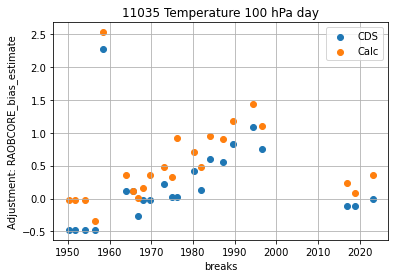

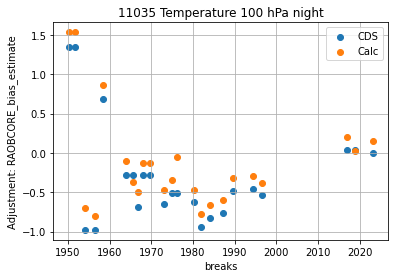

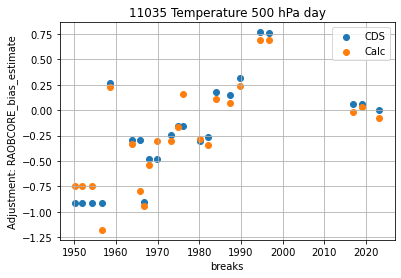

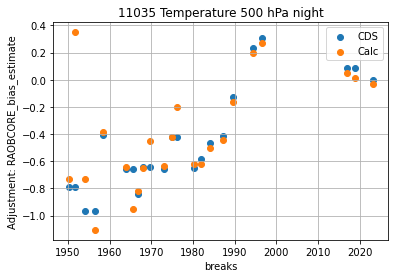

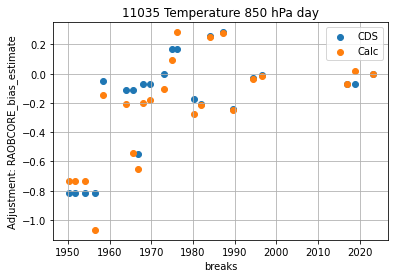

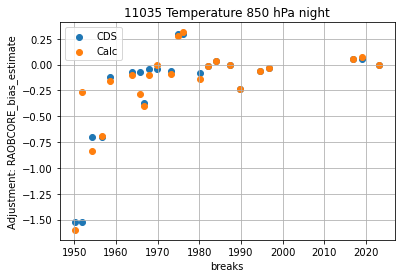

In [20]:
station = '11035'
adj = 'RAOBCORE_bias_estimate'
dates, cd, cn, ad, an = get_adj(station, adj)
plt_adj(dates, cd, ad, 100, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 100, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 500, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 500, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 850, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 850, station, 'night', adj, save=False)

2021-04-29 11:42:03,488 INFO Welcome to the CDS
2021-04-29 11:42:03,489 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-04-29 11:42:03,562 INFO Request is completed
2021-04-29 11:42:03,563 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data2/adaptor.comprehensive_upper_air.retrieve-1619418957.6919405-22674-5-9bd54766-c124-49e5-9fde-f2fdec5cb266.zip to download.zip (29M)
  0%|          | 0.00/29.0M [00:00<?, ?B/s]

[  10.   20.   30.   50.   70.  100.  150.  200.  250.  300.  400.  500.
  700.  850.  925. 1000.]


2021-04-29 11:42:08,084 INFO Download rate 6.4M/s   
2021-04-29 11:42:08,222 INFO Reading Profile on slice(None, None, None)


1925-01-24 09:22:00


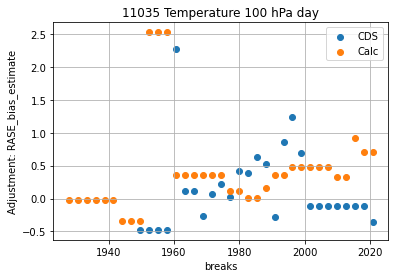

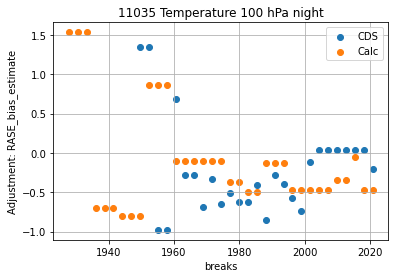

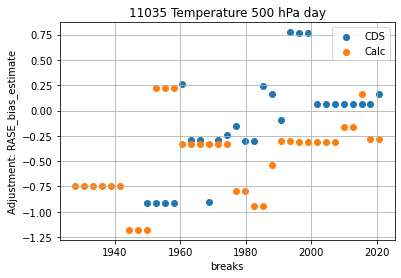

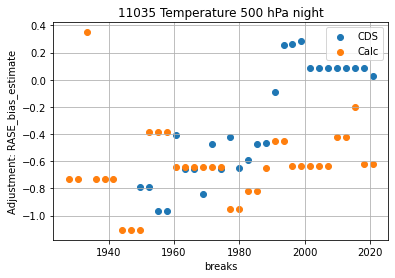

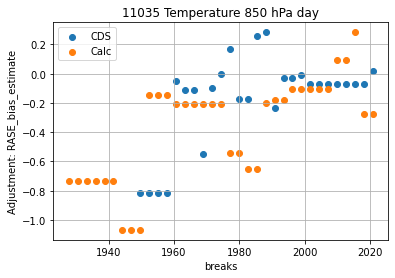

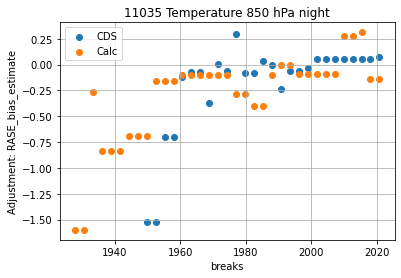

In [21]:
station = '11035'
adj = 'RASE_bias_estimate'
dates, cd, cn, ad, an = get_sacadj(station, adj)
plt_adj(dates, cd, ad, 100, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 100, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 500, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 500, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 850, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 850, station, 'night', adj, save=False)

2021-04-29 11:42:39,101 INFO Welcome to the CDS
2021-04-29 11:42:39,101 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-04-29 11:42:39,289 INFO Request is completed
2021-04-29 11:42:39,290 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data2/adaptor.comprehensive_upper_air.retrieve-1619418957.6919405-22674-5-9bd54766-c124-49e5-9fde-f2fdec5cb266.zip to download.zip (29M)
2021-04-29 11:42:43,265 INFO Download rate 7.3M/s   
2021-04-29 11:42:43,368 INFO Reading Profile on slice(None, None, None)


1925-01-24 09:22:00
[datetime.datetime(1900, 1, 2, 0, 0), datetime.datetime(1950, 2, 26, 0, 0), datetime.datetime(1951, 9, 13, 0, 0), datetime.datetime(1954, 3, 1, 0, 0), datetime.datetime(1956, 7, 5, 0, 0), datetime.datetime(1958, 6, 24, 0, 0), datetime.datetime(1963, 11, 9, 0, 0), datetime.datetime(1965, 8, 15, 0, 0), datetime.datetime(1966, 10, 24, 0, 0), datetime.datetime(1968, 1, 2, 0, 0), datetime.datetime(1969, 9, 30, 0, 0), datetime.datetime(1973, 2, 14, 0, 0), datetime.datetime(1974, 11, 22, 0, 0), datetime.datetime(1976, 2, 4, 0, 0), datetime.datetime(1980, 3, 31, 0, 0), datetime.datetime(1982, 1, 9, 0, 0), datetime.datetime(1984, 1, 10, 0, 0), datetime.datetime(1987, 4, 17, 0, 0), datetime.datetime(1989, 8, 24, 0, 0), datetime.datetime(1994, 6, 5, 0, 0), datetime.datetime(1996, 8, 12, 0, 0), datetime.datetime(2016, 12, 15, 0, 0), datetime.datetime(2018, 12, 16, 0, 0), datetime.datetime(2023, 3, 15, 0, 0)]


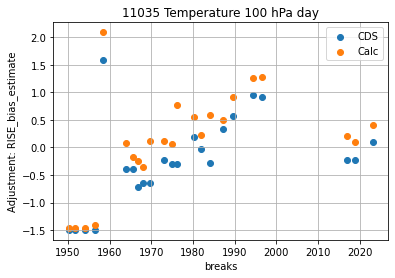

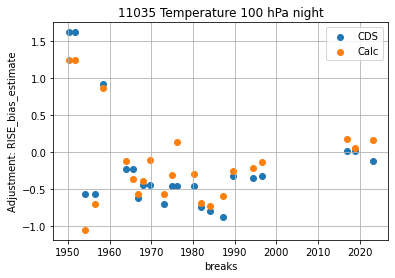

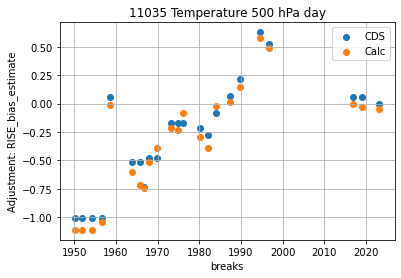

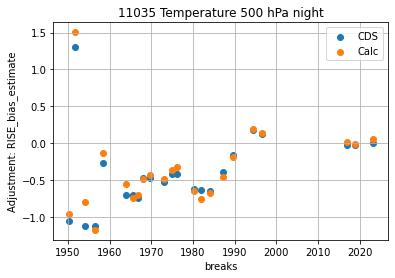

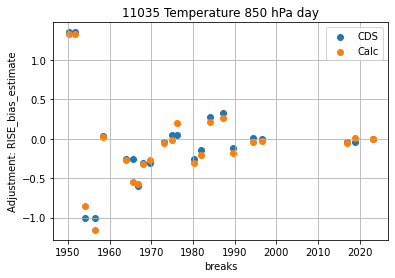

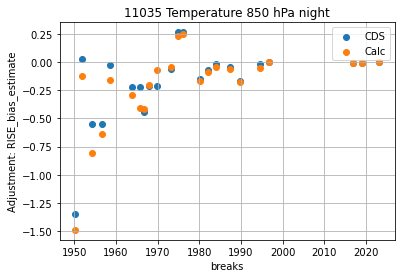

In [22]:
station = '11035'
adj = 'RISE_bias_estimate'
dates, cd, cn, ad, an = get_adj(station, adj)
plt_adj(dates, cd, ad, 100, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 100, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 500, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 500, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 850, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 850, station, 'night', adj, save=False)

2021-04-29 11:43:05,768 INFO Welcome to the CDS
2021-04-29 11:43:05,769 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-04-29 11:43:05,847 INFO Request is completed
2021-04-29 11:43:05,847 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data2/adaptor.comprehensive_upper_air.retrieve-1619418957.6919405-22674-5-9bd54766-c124-49e5-9fde-f2fdec5cb266.zip to download.zip (29M)


[  10.   20.   30.   50.   70.  100.  150.  200.  250.  300.  400.  500.
  700.  850.  925. 1000.]


2021-04-29 11:43:09,234 INFO Download rate 8.6M/s   
2021-04-29 11:43:09,336 INFO Reading Profile on slice(None, None, None)


1925-01-24 09:22:00


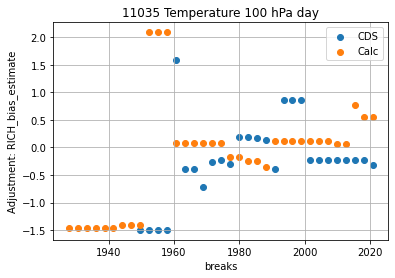

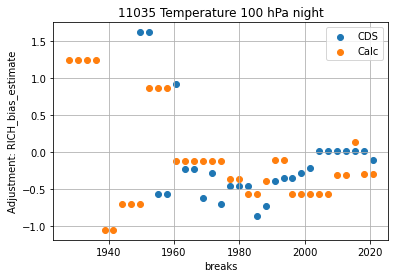

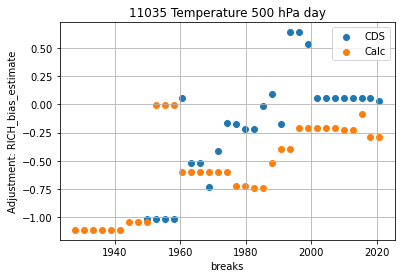

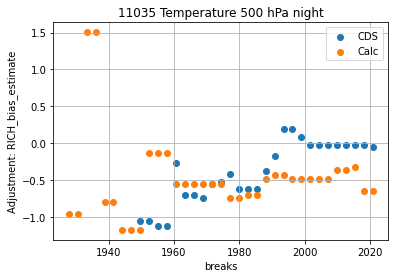

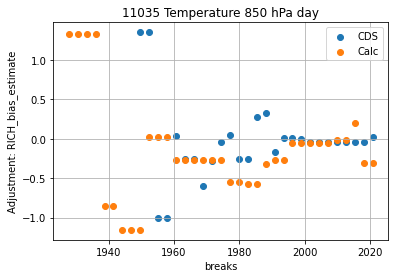

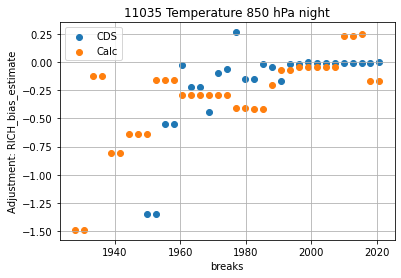

In [23]:
station = '11035'
adj = 'RICH_bias_estimate'
dates, cd, cn, ad, an = get_sacadj(station, adj)
plt_adj(dates, cd, ad, 100, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 100, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 500, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 500, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 850, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 850, station, 'night', adj, save=False)